# LSUN Bedrooms

In [1]:
import os

In [2]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob
from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary cache directory at /tmp/matplotlib-tczf49lg because the default path (/home/dom/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import timm

In [5]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [8]:
path_data = Path('../data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [10]:
import shutil
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive(path_zip, path_data)

In [12]:
bs = 64

In [13]:
def to_img(f): return read_image(f, mode=ImageReadMode.RGB) / 255

In [14]:
class ImagesDS:
    def __init__(self, spec):
        self.path= Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return to_img(self.files[i])[:, :256, :256]

In [16]:
ds = ImagesDS(path/f'**/*.jpg')

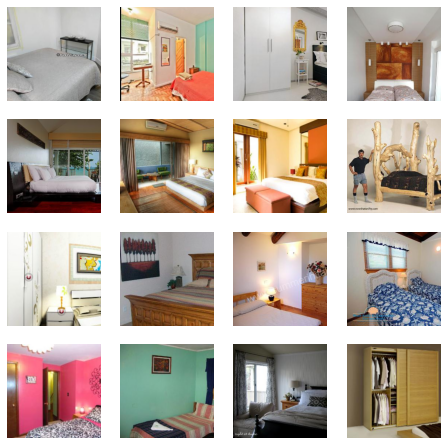

In [17]:
dl = DataLoader(ds, batch_size=bs, num_workers=fc.defaults.cpus)
xb = next(iter(dl))
show_images(xb[:16], imsize=2)

In [18]:
xb[:16].shape

torch.Size([16, 3, 256, 256])

In [19]:
16*3*256*256

3145728

## VAE

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(def_device).requires_grad_(False)

In [ ]:
xe = vae.encode(xb.to(def_device))

In [ ]:
xs = xe.latent_dist.mean[:16]
xs.shape

In [11]:
# compression
(16*3*256*256)/(16*4*32*32)

48.0

In [ ]:
show_images(((xs[:16,:3])/4).sigmoid(), imsize=2)

In [ ]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'].clamp(0, 1), imsize=2)

In [ ]:
mmpath = path_data/'bedroom/data.npmm'

In [ ]:
len(ds)

In [ ]:
mmshape = (len(ds), 4, 32, 32)

In [ ]:
if not mmpath.exists():
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for b in progress_bar(dl):
        n = len(b)
        a[i:i+n] = to_cpu(vae.encode(b.to(def_device)).latent_dist.mean).numpy()
        i += n
    a.flush()
    del(a)

In [ ]:
lats = np.memmap(mmpath, np.float32, mode='r', shape=mmshape)

In [ ]:
b = torch.tensor(lats[:16])
xd = to_cpu(vae.decode(b.to(def_device)))
show_images(xd['sample'].clamp(0, 1), imsize=2)